# Introduction
Here we will explain how to perform the analysis of an AB test. Usually when people speak about AB testing they discuss
which statistical test is the best to define if an AB test was successful or not. Starting thinking about the statistical
test when we think about AB testing in an error. Indeed, even thinking about "successful" and "non-succesful" AB test
is a little annoying. These are two of many common errors I noticed with the time.

We will do a complete and detailed analysis of an AB test here, but it's important before of that to do some reflection.
Before we start to code even one line we need to have the right mind set, we need to understand what the target of any
AB test is. Let's start with some common misunderstandings:
* Well-designed AB test are successful in any case, even if the outcome is not the expected one. What matters are the learnings, a well-designed AB test will allow us to plan the next steps on top of it, again, even if the outcome is not the expected one.
* AB testing is a tool, not a stopper. I often heard different people complaining about the time AB testing takes and how it's delaying the implementation of new features. The problem is that once a new feature is implemented if something goes wrong we are not able to be 100% sure if it's because of the new feature. Indeed, even if everything goes well, we will not be able to ensure that it happened because of the new feature. Correlation and causation are two different things.
* In the theory AB testing is mostly about the statistical techniques to evaluate different variants and proof or reject a hypothesis. In real life the things are a little different. Indeed, I would say that in any data related field one of the major subjects is data cleaning and preprocessing. This is specially relevant when we think about how real AB test work, with tools which apply different treatments to different users, but they are also not perfect. If the data is not properly processed, every following step is worthless.
* Statistical test are tools, no statistical test is the best option for all the cases. Depending on our uses there are statistical tests which are better in general, which is not the same. Even so, in many cases simpler approaches are much more robust than highly developed approaches, if we don't really understand why we are selecting a more complex approach we are doing something wrong. As an base rule, the easiest approach which meets our needs is the right approach.

We have now an idea about what AB testing not is, but than, what is AB testing about? AB testing is about investigation.
We test something to learn from it, we start with an initial hypothesis, but only the real experience will tell us
what reality is. Indeed, well-designed AB test don't only evaluate one particular thing, they help us to understand
better the subject of study, allowing us to plan next steps.

With this we will get a feeling about what an well-designed AB test is, but this is a discussion for another article
which will come for sure.

# Statistical tests
If you google statistical test for AB testing you will find half a dozen in just 10 minutes, go ahead and select anyone
of them is enough? Well, you are running going a big risk by doing this. Statistical test evolved over time, all of us surly
saw some of the most basic ones at college or the university. If that is your case, hopefully, your professor repeated
many times the word "assumptions". You can not pick any test and apply it to any set of data, at least not if you want
to get some useful and accurate insights from it.

I will not go into the details of every statistical test, that is out of scope of this article, but I will give you a
general recommendation. Two of the most robust statistical test I would recommend you are the:
* Mann - Whitney U test
* Kolmogorov - Smirnov test

Quick clarification, when I say robust I mean that they have less assumptions on the data than other statistical tests.
They evaluate different things (We will come to it) to define when a change is statistically significant. So, in general
I would recommend using them together. They are easy to understand, with some basic understanding about statistics
they will not be a challenge for you. Indeed, those are the statistical tests we will use here.

I know that other ways to evaluate AB tests are more interesting, as the bayesian approach, but if we don't understand
why and when to go with the bayesian approach and not with this one it's because we need to start with the basics.
Again, as a base rule, the easiest approach which meets our needs is the right approach.

# The analysis
## What are we going to do?
Now, after a quick but really important reflection, let's code a little. What can you expect from this article?
We will face the analysis of an AB test, taking into account additional steps which we need to think of when we do
the analysis of an AB test but are usually skipped in most of the examples I saw.

Also, this dataset we will use is already aggregated, but in some cases we will have more granular data, indeed it's
pretty common to work with user level data. So, I will make some comments on things we have to take care of when we work
with non-pre aggregated data.

## To take into account on user level data
In many of the cases you will handle you will have user level data, which you might want to aggregate to analyze it in
the way I will do here. But, before doing this, let's be aware of some points:
* In real cases, specially in technology orientated companies, AB testing is done with some tools which helps us to select some of our users, split them into variants and apply to any of these variants different treatments. Now, how confident are you that the tool you are using works well? Given my experience I wouldn't be too confident on this. Challenge your tool.
* Is it selecting the amount of users you expected?
* Are the users distributed among the variants in the proportion you set up?
* Did you apply some filters on which users to include in the AB test? Is the tool applying those filters?
* Do you have one user in more than one variant of the same AB test?
* Are you users actually getting the treatment we expect them to get?
* I don't want to become to technically, but do we have enough users in our AB test? Is the sample we are using representative for the whole population? If you do an AB test on 20% of your users to test something (Let's say a feature in a mobile game) with which only 3% of the users interact it could be that your sample size is too small.

Some of those points still applying on aggregated data and we will evaluate them here also.

## Our data
Let's come back to our case, with already aggregated data the dataset I'm going to use is from Kaggle, here is the link
so you can download it https://www.kaggle.com/datasets/ilkeryildiz/example-dataset-for-ab-test (Indeed there are two
datasets, one for each variant).

One of the first things we need to do when we work with new data is to understand what information we have in it.
Here we are working with non-real data, we can't go ahead and ask any teammates, go through documentation, or make
out by ourselves how the data for each column in processed. I would you highly recommend you to take this step very
seriously, here, given the context, I will define any additional clarification the dataset or related documentation
doesn't provide by itself.

## Our study case
"""
A company recently introduced a new bidding type, “average bidding”, as an alternative to its existing bidding type,
called “maximum bidding”. One of our clients, non_real_bidding_company.com, has decided to test this new feature and
wants to conduct an A/B test to understand if the new feature brings more average revenue than maximum bidding.
"""

Let's first define the hypothesis they want to test. They want to now if the average revenue increased because
of this feature. Of course, we will look also into other metrics, but this is the base criteria for this AB test.

Based on this, let's start!

# Initialization
## Imports

In [524]:
import pandas as pd

from scipy.stats import kstest, mannwhitneyu

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data
## Downloads
The datasets we are using are two and come from .

In [385]:
control_df = pd.read_csv('./control_group.csv', delimiter=';')
test_df = pd.read_csv('./test_group.csv', delimiter=';')

We will start joining the datasets together to do the data preprocessing.

In [386]:
df = pd.concat([control_df, test_df])
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre processing
### Transform Dates
First of all we need to transform the format of the dates to avoid any future error. Also, we will transform this column
into the index.

In [387]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df = df.set_index('Date')

### Experiment variants

Checking the experiment variants we can see we have only two variants, the default (or control) one and the
testing variant.

In [388]:
df['Campaign Name'].unique()

array(['Control Campaign', 'Test Campaign'], dtype=object)

### Dataframe primary key
Now, we need to make out which is the granularity level of the data. Here we will see that indeed we have 60 rows one
for each variant for each day. We can make this out by looking into the shapes as we did below.

This is important as we could have a lower granularity level, for instance, by country, which would mean that we have
one row per date, variant, and country. In these cases we can look at the results at country level, or we would need to
aggregate the data.

In [389]:
df.shape

(60, 9)

In [390]:
df['Campaign Name'].reset_index().drop_duplicates().shape

(60, 2)

### Manage nulls
Nulls are something we have to check for in all the cases, indeed usually we need to understand why we are getting a null
value, in some cases it could indicate errors in a process. So, if you see a null value don't just ignore it, at least
ask among your team or yourself what is happening. Below we can see that we have a case as such.

The row for the date 2019-08-05 for the control group has only nulls, here we have two options:
* We can drop this row
* Use any technique to fill those values in

Initially, I would recommend not to fill these cases in if we are not totally sure about what we are doing, we could being
biasing the results. Given the risk we would be running and the low potential gain by filling this value I will just
drop it and only choose another option whe it's really necessary.

But, here we need to make a call-out, as we are working with time series if we take out one date for one of the variants
we need to consider doing the same for the other variant. If not we could be facing problems applying different
statistical methods to evaluate the results. If you have doubts about what to do I would recommend you to drop the
date for both variants.

In [391]:
df.isnull().sum()

Campaign Name          0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [392]:
df[df['# of Impressions'].isnull()]

,Campaign Name,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
Date,,,,,,,,,
2019-08-05,Control Campaign,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
null_date = df[df['# of Impressions'].isnull()].index[0]
df = df[df.index != null_date]

df.shape

(58, 9)

### Normalize metrics
Now, here we have another of the most common errors when evaluating AB tests. This error usually happens because of the
big difference between the theoretical evaluation of an AB test and what actually happens in the practice.
In this experiment we have two different variants, are we sure that the same amount of users have been exposed to each
variant? Usually, I can tell you because of my experience, that this will not be the case, and if we don't be aware of
this we will cause noise in our analysis, or in the worst of the cases totally base our results, making them worthless.

So, what can we do? Usually one of the metrics in your dataset will give you information about how many users have been
exposed to this AB test, a general approach in to normalize all the metrics by this value. In that way you are making
sure that different amount of users exposed to each treatment will not biase your results.

The description of the data isn't that clear about which column tells us how many users have been exposed to the AB
test. In real life, if that happens, stop everything and speaking with every team member or responsible for the data
to understand clearly what information we have at each column. As we can't do this here, and based on the information we
can find in Kaggle about this dataframe I will assume that the column "Reach" defines the amount of users exposed to
this AB test, so I will divide the rest of the columns by this value to normalize the metrics.

Also, let's check quickly if we can make out if really different amount of users have been exposed to the different
variants.

In [394]:
df.groupby('Campaign Name').agg({'Reach':'sum'})

,Reach
Campaign Name,
Control Campaign,2576503.0
Test Campaign,1509609.0


As we can see, one of the variants has been exposed to about 1.000.000 more users than the other. So, if we don't
normalize our metrics our results will be strongly biased. Good that we took this into account.

In [395]:
norm_df = df.copy()

for col in [col for col in norm_df.columns if col not in ['Campaign Name', 'Reach']]:
    norm_df[col] = norm_df[col] / norm_df['Reach']

# Analysis
## Overview
Now, we have the dataset we will use for the analysis, we will start with a quick overview.
We will split the datasets between into two, one for the testing variant, and another for the default variant.

Using the describe function and the style feature pandas has (Nice feature I would recommend to look for at the link
below), let's create a quick summary of our data comparing both variants.

https://pandas.pydata.org/docs/reference/style.html

What we are calculation for each one of the cases if the relative percentage difference, here the idea is just to get
an overview. In that way to can make out what we should expect to see in our futhur analysis.

Just to notice, the values below are percentages, so 1.00 means 100%.

As we can see, the testing variant seems to be performing much better, than the control group. But, if we look at the
"Reach" column we see again that our suspicion was ture, one of the variants has been exposed to many users than the
other.

Analyzing the values below to make out which are more or less meaningfull is an interesting subject, but I don't
want to complicate this first post too much, so please fell free to do it on your end and reach me out with any doubts
you have.

In [396]:
norm_control_df = norm_df[norm_df['Campaign Name'] == 'Control Campaign']
norm_test_df = norm_df[norm_df['Campaign Name'] == 'Test Campaign']

def bg_color(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

control_desc_df = norm_control_df.describe()
test_desc_df = norm_test_df.describe()

(((test_desc_df - control_desc_df) / control_desc_df))\
    .style.format(precision=2)\
    .set_properties(**{'text-align': 'right'})\
    .applymap(bg_color)

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
count,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mean,1.62,0.43,-0.41,1.76,1.45,1.24,0.59,1.26
std,6.62,15.10,0.29,5.06,2.88,3.21,2.40,3.66
min,0.40,-0.01,-0.75,0.64,0.78,0.96,-0.49,0.07
25%,0.66,0.03,-0.58,0.53,1.02,0.97,0.05,0.57
50%,1.00,0.07,-0.53,1.77,1.14,0.68,0.05,0.73
75%,1.62,0.21,-0.26,1.39,1.03,0.91,0.43,1.07
max,4.66,6.07,-0.14,5.33,3.15,3.60,2.46,4.01


## Pairplot

Now we will plot a pairplot to get an general visual overview of the metrics.

Some points to take into account when working on a pairplot:
* This is usually a heavy graph, here our dataset is really small, but if you are working with a bigger datasets, which this function can handle, consider sampling your dataset.
* The lower and upper triangle of the graph show the same, but with the inverted axis, so:
    * One way to reduce the processing when creating this graph is setting corner=True, in that way only the lower triangle will be plotted which dosen't matter.
    * If you're plotting the lower and upper triangle consider adding something extra to one of the triangles as I did here with KDE plot.

Looking at these graphs we see that the complete distribution of the metric changed at the testing variant compared
to the control group.

c:\users\aleja\documents\trabajo\medium\quick start for ab testing\venv\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.

c:\users\aleja\documents\trabajo\medium\quick start for ab testing\venv\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.

c:\users\aleja\documents\trabajo\medium\quick start for ab testing\venv\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.

c:\users\aleja\documents\trabajo\medium\quick start for ab testing\venv\lib\site-packages\seaborn\distributions.py:1213: UserWarning:

No contour levels were found within the data range.



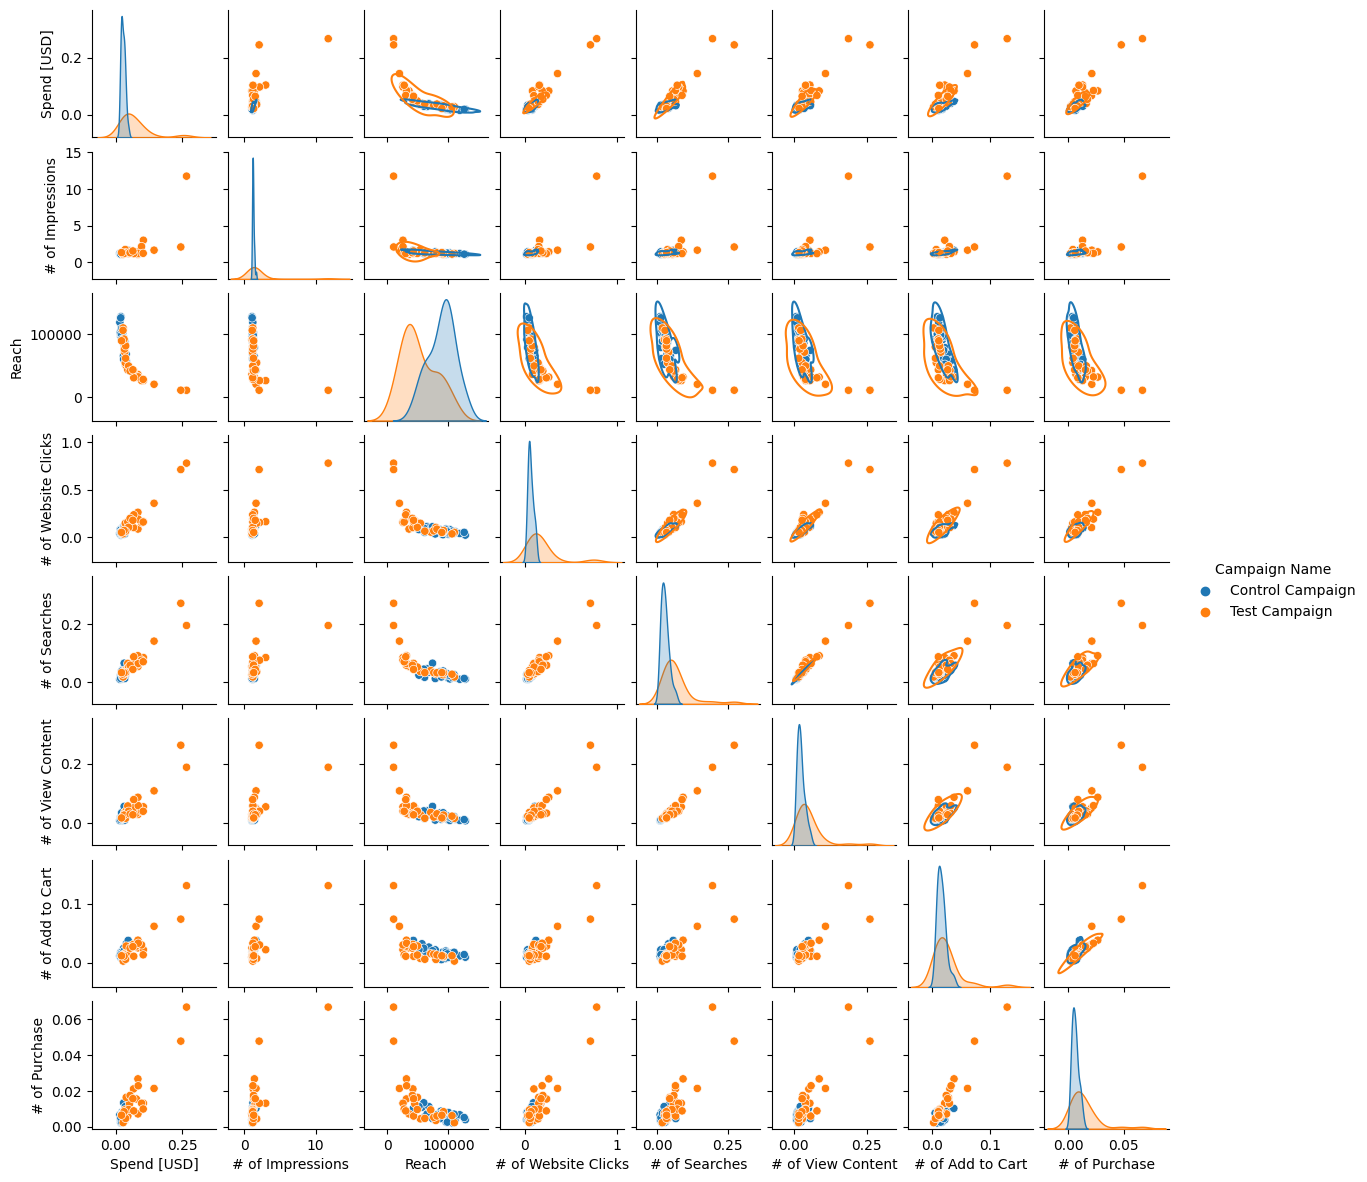

In [398]:
fig = sns.pairplot(norm_df.reset_index(), hue="Campaign Name", height=1.5, corner=False)
fig.map_upper(sns.kdeplot, levels=1)

## Time Series & Boxplot
Let's look at this metrics over time, to make out if we can get any other insides. We should not forget that we
are working with time series, not independent datapoints, so we could even make out some patterns over time by
looking at the line plots.

To do this we will join the data again, but we don't will stack one dataframe over the other, we will join them
horizontally.

In [399]:
h_df = pd.merge(
    norm_control_df,
    norm_test_df,
    left_index=True,
    right_index=True,
    suffixes=('_cont', '_test')
).drop(['Campaign Name_cont', 'Campaign Name_test'], axis=1)

Also we will calculate the daily difference between  the variants for each metric. We can calculate
the daily relative difference, this is what I would usually suggest, but if you are working with tiny numbers as
here this could mean huge values which are harder to analyze and I would recommend to avoid, specially if you need to
present you work later on to other people.

In [400]:
h_df = h_df.sort_index()

for col in set([val.split('_')[0] for val in h_df.columns]):
    h_df[col + '_diff'] = (h_df[col + '_test'] - h_df[col + '_cont'])# / h_df[col + '_cont']

Looking at the time series we see that among all the metrics two dates seems to be outliers 2019-08-12 and 2019-08-19
usually in a normal case this can be suspicious and at least we should check if something happened during these dates.
Also, looking at the boxplot it seems like that these values are possible anomalies, let's assume for our case that we
checked these days, and it actually comes out that some problems happened these days which caused the anomalies, in our
case we will take them out from our dataset. In real cases we need to be sure to investigate these cases and that they
are anomalies if we finally decide to take them out.


In [515]:
def ab_test_plot(df, metric_def, metric_test, metric_diff):

    # Line plot
    fig = make_subplots(rows=1, cols=2, specs=[[{"secondary_y": True}, {"secondary_y": True}]])
    fig.add_trace(go.Scatter(
            x=df.index,
            y=df[metric_def],
            name="Control",
            line_shape='linear',
            line = dict(color='royalblue',
                        width=4)
        ), row=1, col=1)

    fig.add_trace(go.Scatter(
            x=df.index,
            y=df[metric_test],
            name="Testing",
            line_shape='linear',
            line = dict(color='orange', width=4)
        ), row=1, col=1)

    fig.add_trace(go.Scatter(
            x=df.index,
            y=df[metric_diff],
            name="Difference",
            line_shape='linear',
            line = dict(color='red', width=3),
        opacity=0.3
        ), row=1, col=1,
        secondary_y=True)

    # Box plot
    fig.add_trace(go.Box(x=df[col + '_cont'], name='Control', boxpoints='all'), row=1, col=2)
    fig.add_trace(go.Box(x=df[col + '_test'], name='Testing', boxpoints='all'), row=1, col=2)

    fig.update_layout(
        title_text=metric_def.split('_')[0],
        yaxis=dict(title_text='Value'),
        yaxis2=dict(title_text='Difference'),
        width=1000, height=400)

    fig.show()

In [516]:
for col in set([col.split('_')[0] for col in h_df.columns]):
    ab_test_plot(h_df, col + '_cont', col + '_test', col + '_diff')

### Dropping anomalies

In [517]:
clean_df = h_df[~h_df.index.isin(['2019-08-12', '2019-08-19'])]

Lets quickly check if it worked

In [518]:
ab_test_plot(clean_df, '# of View Content_cont', '# of View Content_test', '# of View Content_diff')


# Statistical test
Now we have a good understanding of our data, we cleaned it, took out all the anomalies. Now the question is, go we see
statistically significant changes among our variants to say that the hypothesis of our AB test has been meet?
Besides of the hypothesis, we will apply this statistical verification to all our metrics to detect any possible change-

There are several tests we could apply, most of them would need to tu preprocess in someway more our data, to keep it
easy, but not less efficient because of this we will apply two non-parametric tests. Why two? Because each test checks
for something different, in this way we can have more confident in our results, as we looked into the data with
two different criterias.

The tests we will apply are:
* Mann - Whitney U test
* Kolmogorov - Smirnov

In [547]:
results_list = list ()

clean_df = clean_df.sort_index()

for col in set([col.split('_')[0] for col in clean_df.columns]):
    results_dict = dict()

    results_dict['metric'] = col
    _, results_dict['kstest'] = kstest(clean_df[col + '_cont'], clean_df[col + '_test'])
    _, results_dict['mwtest'] = mannwhitneyu(clean_df[col + '_cont'], clean_df[col + '_test'])

    results_list.append(results_dict)

## Final results
As we can see, we are getting statistical significant results for most of the metrics (p-values <= 0.05).
The only two metrics we dosen't seems to change that much, or at least dosen show a statistical significant change are
the amount of times the item has been add to cart and the amount of impressions.

In [574]:
def test_color(col):
    if col.name in ['kstest', 'mwtest']:

        return ['color: green' if val <= 0.05 else 'color: red' for val in col.values]
    else:
        return [''] * len(col.values)

pd.DataFrame(results_list).style\
    .format(precision=2)\
    .set_properties(**{'text-align': 'right'})\
    .apply(test_color)

,metric,kstest,mwtest
0,Reach,0.00,0.00
1,# of Purchase,0.05,0.00
2,# of View Content,0.01,0.00
3,# of Searches,0.00,0.00
4,Spend [USD],0.00,0.00
5,# of Add to Cart,0.19,0.37
6,# of Impressions,0.19,0.10
7,# of Website Clicks,0.00,0.00
